# Manipulating expression trees

## Structure of complex expressions

Recall from the previous notebook that we want to know how Julia represents a complex expression with more than one operation, e.g.:

In [4]:
ex = :(x + y * z)

:(x + y * z)

As usual, we can use `dump` to see the structure:

In [5]:
dump(ex)

Expr
  head: Symbol call
  args: Array{Any}((3,))
    1: Symbol +
    2: Symbol x
    3: Expr
      head: Symbol call
      args: Array{Any}((3,))
        1: Symbol *
        2: Symbol y
        3: Symbol z


In [6]:
ex.args

3-element Vector{Any}:
 :+
 :x
 :(y * z)

In [7]:
ex.args[3]

:(y * z)

In [9]:
typeof(ex.args[3])

Expr

We see that indeed we have *one `Expr` object embedded into another!* That is, one of the `args` of the top-level expression `ex` is *another* object of type `Expr`:

In [9]:
ex.args[3]

:(y * z)

In [10]:
typeof(ex.args[3])

Expr

We can say that the `Expr` type in Julia is a [**recursive data type**](https://en.wikipedia.org/wiki/Recursive_data_type#:~:text=In%20computer%20programming%20languages%2C%20a,usually%20viewed%20as%20directed%20graphs.): an object of type `Expr` can contain other `Expr` objects! This is another good reason why the type of the `args` field is a vector of `Any`!

This fact has important implications for how we need to work with `Expr` objects.

Another example is an assignment:

In [30]:
dump( :(x = y + z) )

Expr
  head: Symbol =
  args: Array{Any}((2,))
    1: Symbol x
    2: Expr
      head: Symbol call
      args: Array{Any}((3,))
        1: Symbol +
        2: Symbol y
        3: Symbol z


As we have seen, any piece of code that is more complicated than a single function call has a **hierarchical**, or **nested** structure, with `Expr`s contained inside other `Expr`s. In this section we will see how to manipulate such structures. It is common to think of them as **trees**, called **abstract syntax trees** or **ASTs**, or **computational graphs**.

There are several packages that enable us to visualise an expression as a tree, for example the `TreeView.jl` package that I wrote, and [GraphRecipes.jl](https://github.com/JuliaPlots/GraphRecipes.jl).

In [10]:
using TreeView

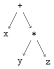

In [11]:
@tree x + y * z  # uses TikzGraphs package

Each internal node of the graph corresponds to a new `Expr`.

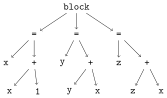

In [16]:
ex = quote
    x = x + 1
    y = y + x
    z = z + x
end

ex = Base.remove_linenums!(ex)

TreeView.walk_tree(ex)

In [14]:
ex

quote
    x = x + 1
    y = y + x
end

In [15]:
ex.head

:block

## Walking through expression trees

Since complex expressions have a **recursive** structure, we need to take this into account when we process them.
As a simple example, let's try to solve the following problems:

> Given an expression, substitute `y` for `x`, i.e. replace each `x` in the expression with a `y`.

The easiest way to do this is to *modify* the expression.

How can we do this? We will need to check each argument to see if it's an `:x`. If it is, we replace it; if not, we move on:

## Exercise

1. Write a function `substitute!` that takes an expression and replaces each `:x` with `:y`.

2. Test it on the expression `x + x * y`. Does it work correctly? If not, what is it missing?

[Deliberately blank!]

In [17]:
function substitute!(ex)
    for i in 1:length(ex.args)

        if ex.args[i] == :x
            ex.args[i] = :y
        end
         
    end
    
    return ex
end

substitute! (generic function with 1 method)

In [18]:
ex = :(x + x * y)

:(x + x * y)

In [19]:
substitute!(ex)

:(y + x * y)

In [20]:
ex.args

3-element Vector{Any}:
 :+
 :y
 :(x * y)

In [21]:
function substitute!(ex)
    for i in 1:length(ex.args)

        if ex.args[i] == :x
            ex.args[i] = :y
        
        elseif ex.args[i] isa Expr  # if typeof(ex.args[i]) === Expr
            substitute!(ex.args[i])  # recursive call!
        end
    end
    
    return ex
end

substitute! (generic function with 1 method)

In [22]:
ex = :(x + x * y)

:(x + x * y)

In [23]:
substitute!(ex)

:(y + y * y)

In [24]:
ex = :(x + 1)
substitute!(ex)

:(y + 1)

In [25]:
ex = :x
substitute!(ex)

LoadError: type Symbol has no field args

#### Exercise

Deal with the case of just a symbol.

In [57]:
function substitute!(ex)
    args = ex.args  # for ease
    
    for i in 1:length(args)
        if args[i] == :x
            args[i] = :y
        end
    end
    
    return ex
end

substitute! (generic function with 1 method)

In [58]:
ex = :(x + x * y)

:(x + x * y)

In [59]:
substitute!(ex)

:(y + x * y)

Oops -- only one `x` was replaced. That's because the other ones are... *hidden inside recursive `Expr`s*! So we need to explicitly handle that case. To do so, we need to
delve *inside* each such `Expr` and... call the function `substitute!` on it! Thus `substitute!` becomes a **recursive function**.

In [60]:
function substitute!(ex)
    args = ex.args  # for ease
    
    for i in 1:length(args)
        if args[i] == :x
            args[i] = :y
        
        elseif args[i] isa Expr
            substitute!(args[i])
        end
    end
    
    return ex
end

substitute! (generic function with 1 method)

In [62]:
ex = :(x + x * y)

:(x + x * y)

In [63]:
substitute!(ex)

:(y + y * y)

Now *all* `x`s were successfully replaced! But note that the original expression has been lost:

In [64]:
ex

:(y + y * y)

In [26]:
ex

:x

Although the code is *easier to write* using mutation (since otherwise we need to build up a similar expression with the same structure, which is possible but trickier), users probably don't expect or want their expression to be mutated, since you cannot then recover the original expression, which you might need later. It is common to then provide a *non-mutating* version, by making a copy of the original expression and mutating that.

In [43]:
function substitute(ex)
    ex2 = deepcopy(ex)
    substitute!(ex2)
    
    return ex2
end

substitute (generic function with 1 method)

In [65]:
ex = :(x + x * y)

:(x + x * y)

In [66]:
substitute(ex)

:(y + y * y)

The original expression has now not changed:

In [67]:
ex

:(x + x * y)

Note that it would have been tempting to write this by iterating over the arguments using `for arg in ex.args ...`, but that will *not* work, since you then *cannot* modify the resulting argument in place within the expression &ndash; `arg` is a *copy* of the immutable object inside the expression, rather than a *reference* to it:

In [50]:
ex = :(x + y)

:(x + y)

In [54]:
for arg in ex.args
    @show arg
    arg = :z
end

arg = :+
arg = :x
arg = :y


In [53]:
ex

:(x + y)

In [27]:
:( (x + y) * z )

:((x + y) * z)

In [28]:
1 == 1.0

true

In [29]:
1 === 1.0

false

## Exercise

1. Make the `substitute` function more general, by specifying what to substitute with what

## Exercise

1. Find which variables are used inside an expression

   For example, the expression `2x + y * x - 1` should return the vector `[x, y]`, removing duplicates.
   
   Hint: This requires returning the vector of variables.


[Deliberately blank]

In [45]:
function find_variables(ex)
    all_variables = []
    
    for arg in ex.args[2:end]   # OK because not modifying
        if arg isa Symbol
            push!(all_variables, arg)
            
        elseif arg isa Expr
            push!(all_variables, find_variables(arg))
        end
    end
    
    return sort(unique(vcat(all_variables...))
end

find_variables (generic function with 1 method)

In [46]:
find_variables(:(x + x * y))

LoadError: MethodError: no method matching isless(::Symbol, ::Vector{Any})
[0mClosest candidates are:
[0m  isless([91m::AbstractVector{T} where T[39m, ::AbstractVector{T} where T) at abstractarray.jl:1989
[0m  isless(::Symbol, [91m::Symbol[39m) at strings/basic.jl:350
[0m  isless(::Any, [91m::Missing[39m) at missing.jl:88
[0m  ...

In [41]:
find_variables(:(z = x + y))

2-element Vector{Symbol}:
 :x
 :y

## Solution to `find_variables`

We need to recursively walk the expression and pick out which things are variables and which are not.
For this we need to realize that there are different types of objects at the leaves of the tree (i.e. which are not themselves expressions), in particular numbers and symbols.

One way to write this is as follows:

In [2]:
function find_variables(ex)
    if ex isa Number
        return []

    elseif ex isa Symbol
        return [ex]
        
    end
    
    # If we have reached here then ex is an Expr
    
    args = ex.args
        
    all = [ find_variables(arg) for arg in args[2:end] ]
    return all
end


find_variables (generic function with 1 method)

In [3]:
find_variables(:(x + x * y))

2-element Vector{Vector{T} where T}:
 [:x]
 [[:x], [:y]]

In [4]:
find_variables(:(z = x + y))

1-element Vector{Vector{Vector{Symbol}}}:
 [[:x], [:y]]

We see that the idea is on the right track, but there is some more work to do!

But first let's remark that it is usually an **anti-pattern** to use `isa` in Julia! [Recall that `x isa T` tests if the object `x` has type `T`.]
This should usually be replaced by **dispatch**! We can rewrite the same code as follows:

In [5]:
find_variables(ex::Number) = []
find_variables(ex::Symbol) = [ex]

find_variables(ex::Expr) = [ find_variables(arg) for arg in ex.args[2:end] ]

find_variables (generic function with 4 methods)

In [6]:
find_variables(:(z = x + y))

1-element Vector{Vector{Vector{Symbol}}}:
 [[:x], [:y]]

On the other hand, it's not clear (to the author) that this is any faster. It is more elegant and (possibly) reduces cognitive overhead.

## Exercise 

1. Correct `find_variables` so that it returns a list of the unique variables in the expression. Make sure that `z = x + y` works correctly (returning `[x, y, z]`).

[Blank!]

- Which variables are used somewhere in an expression?

In [15]:
find_variables(x::Symbol) = [x]
find_variables(x::Real) = []

find_variables(x::Expr) = sort(unique(reduce(vcat, find_variables(arg) for arg in x.args[2:end])))

find_variables (generic function with 3 methods)

This is still not correct, since it doesn't handle assignment. For that we need an explicit check of the `ex.head`.
This is because Julia's `Expr` type is really untyped; there is no different type like `Assignment` that we could check using dispatch.
This is a small example showing that metaprogramming is *hard*: there can be lots of corner cases to deal with!

## Quote blocks

For longer pieces of code it is common to use `quote ... end` instead of `:( ... )`:

In [18]:
ex = quote
    x = x + 1
    y = y + x
end

quote
    #= In[18]:2 =#
    x = x + 1
    #= In[18]:3 =#
    y = y + x
end

Note that quote blocks automatically embed line number information telling you where that piece of code was created, for debugging purposes.
We can remove that with `Base.remove

In [20]:
Base.remove_linenums!(ex)

quote
    x = x + 1
    y = y + x
end

In [21]:
dump( Base.remove_linenums!(ex) )

Expr
  head: Symbol block
  args: Array{Any}((2,))
    1: Expr
      head: Symbol =
      args: Array{Any}((2,))
        1: Symbol x
        2: Expr
          head: Symbol call
          args: Array{Any}((3,))
            1: Symbol +
            2: Symbol x
            3: Int64 1
    2: Expr
      head: Symbol =
      args: Array{Any}((2,))
        1: Symbol y
        2: Expr
          head: Symbol call
          args: Array{Any}((3,))
            1: Symbol +
            2: Symbol y
            3: Symbol x


The only new feature here is that a quote **block** is a new type of `Expr` with `head` equal to `:block`.

## Futher exercises

1. Given an expression, wrap all the literal values (numbers) in the expression with a wrapper type.

2. Replace each of `+`, `-`, `*` and `/` with the corresponding **checked** operation, which checks for overflow. E.g. `+` should be replaced by `Base.checked_add`.

In [47]:
using IntervalArithmetic

In [49]:
x = big"0.1" + sin(big"0.2")

0.2986693307950612154594126271183897503702067295402054039863959913979707283811691

In [50]:
@interval 0.1 + sin(0.2)

[0.298669, 0.29867]

In [51]:
@interval 0.1

[0.0999999, 0.100001]

In [52]:
@macroexpand @interval 0.1 + sin(0.2)

:(IntervalArithmetic.Interval(IntervalArithmetic.atomic(IntervalArithmetic.Interval{(IntervalArithmetic.parameters).precision_type}, 0.1) + sin(IntervalArithmetic.atomic(IntervalArithmetic.Interval{(IntervalArithmetic.parameters).precision_type}, 0.2))))

In [54]:
IntervalArithmetic.atomic(Interval{Float64}, 0.1)

[0.0999999, 0.100001]

`make_interval(0.1) + sin(make_interval(0.2))`

In [62]:
Base.checked_mul(1.0e308, 1.0e10)

LoadError: MethodError: no method matching checked_mul(::Float64, ::Float64)
[0mClosest candidates are:
[0m  checked_mul(::T, ::T, [91m::T[39m) where T at checked.jl:294
[0m  checked_mul(::T, ::T, [91m::T[39m, [91m::T[39m) where T at checked.jl:296
[0m  checked_mul(::T, ::T, [91m::T[39m, [91m::T[39m, [91m::T[39m) where T at checked.jl:298
[0m  ...

In [61]:
?Base.checked_mul

```
Base.checked_mul(x, y)
```

Calculates `x*y`, checking for overflow errors where applicable.

The overflow protection may impose a perceptible performance penalty.
